# Brain Tumor Classification from MRI

Importing the necessary libraries and modules.

In [1]:
import numpy as np # l|inear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

In [2]:
# Imports 
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import sklearn
import random
import tensorflow as tf
import os
from tqdm import tqdm
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [3]:
# base_path and labels.
base_path = '../input/brain-tumor-classification-mri/'
labels = ['no_tumor', 'pituitary_tumor', 'meningioma_tumor', 'glioma_tumor']

In [4]:
# Constants
IMAGE_SIZE = 150
BATCH_SIZE = 32
VERBOSE = 1

Reading the dataset.

In [5]:
# Dataset from the training folder.
x_train=[]
y_train=[]
for i in labels:
    folderPath = os.path.join(os.path.join(base_path,'Training'),i)
    for j in tqdm(os.listdir(folderPath)):
        img = cv2.imread(os.path.join(folderPath,j))
        img = cv2.resize(img, (IMAGE_SIZE,IMAGE_SIZE))
        x_train.append(img)
        y_train.append(i)
print('Training dataset Loading complete.')

# Dataset from the testing folder..

for i in labels:
    folderPath = os.path.join(os.path.join(base_path,'Testing'),i)
    for j in tqdm(os.listdir(folderPath)):
        img = cv2.imread(os.path.join(folderPath,j))
        img = cv2.resize(img, (IMAGE_SIZE,IMAGE_SIZE))
        x_train.append(img)
        y_train.append(i)
x_train = np.array(x_train)
y_train = np.array(y_train)
x_train, y_train = sklearn.utils.shuffle(x_train, y_train, random_state=0)

print('Testing dataset Loading complete.')

 14%|█▍        | 15/105 [00:00<00:00, 148.54it/s]

Training dataset Loading complete.


100%|██████████| 100/100 [00:00<00:00, 105.84it/s]


Testing dataset Loading complete.


Encoding the y_train and y_test to numbers and one-hot encoding it.

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


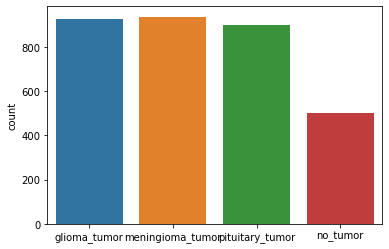

In [6]:
sns.countplot(y_train)
plt.show()

Sample images of each class

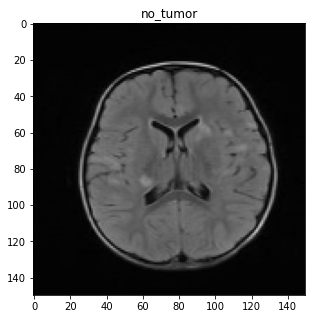

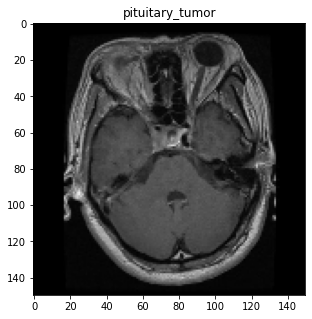

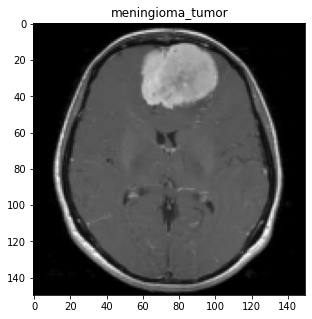

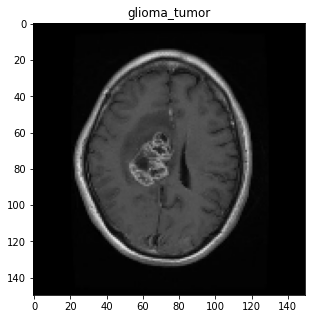

In [7]:
j=0
for i in labels:
    j=0
    while True :
        if y_train[j]==i:
            plt.figure(figsize = (5,5))
            plt.imshow(x_train[j])
            plt.title(y_train[j])
            break
        j+=1

In [8]:
datagen = ImageDataGenerator(
    featurewise_center=False,
    samplewise_center=False,
    featurewise_std_normalization=False,
    samplewise_std_normalization=False,
    zca_whitening=False,
    rotation_range=40, ##EXPERIMENT 2 CHANGE
    width_shift_range=0.2,  ##EXPERIMENT 2 CHANGE
    height_shift_range=0.2, ##EXPERIMENT 2 CHANGE
    zoom_range=0.1, ##EXPERIMENT 2 CHANGE
    horizontal_flip=True, vertical_flip= True ##EXPERIMENT 2 CHANGE
)

datagen.fit(x_train)
x_train.shape

(3264, 150, 150, 3)

In [9]:
# Splitting of dataset for Testing.
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, test_size = 0.20, random_state=0) #change test size ##EXPERIMENT 2 CHANGE

print("Shapes X : Train :",x_train.shape,  " Test :",x_test.shape)
print("Shapes Y : Train :",y_train.shape,  " Test :",y_test.shape)


Shapes X : Train : (2611, 150, 150, 3)  Test : (653, 150, 150, 3)
Shapes Y : Train : (2611,)  Test : (653,)


Encoding the y_train and y_test to numbers and one-hot encoding it.

In [10]:
y_train_new = []
for i in y_train:
    y_train_new.append(labels.index(i))
y_train = y_train_new
y_train = tf.keras.utils.to_categorical(y_train)


y_test_new = []
for i in y_test:
    y_test_new.append(labels.index(i))
y_test = y_test_new
y_test = tf.keras.utils.to_categorical(y_test)

## 1. MODEL:EfficientNetB0

In [11]:
# Importing the model and initializing.
from tensorflow.keras.applications import EfficientNetB0
effnet = EfficientNetB0(weights = 'imagenet',include_top=False,input_shape=(IMAGE_SIZE,IMAGE_SIZE, 3))

16711680/16705208 [==============================] - 0s 0us/step


In [12]:
# Adding Top Layers.
model1 = effnet.output
model1 = tf.keras.layers.GlobalAveragePooling2D()(model1)
model1 = tf.keras.layers.Dropout(0.5)(model1) 
model1 = tf.keras.layers.Dense(4, activation = 'softmax')(model1)
model1 = tf.keras.models.Model(inputs = effnet.input, outputs = model1)

1.1 Model Summary.

In [13]:
# Model summary.
model1.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
rescaling (Rescaling)           (None, 150, 150, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
normalization (Normalization)   (None, 150, 150, 3)  7           rescaling[0][0]                  
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, 151, 151, 3)  0           normalization[0][0]              
______________________________________________________________________________________________

In [14]:
# Compiling Model
model1.compile(loss = 'categorical_crossentropy', optimizer ='Adam', metrics=['accuracy'])

In [15]:
# Callbacks.
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard, ModelCheckpoint
tensorboard = TensorBoard(log_dir = 'logs')
checkpoint = ModelCheckpoint("effnet.h5",monitor="val_accuracy",save_best_only=True,mode="auto",verbose=1)
reduce_lr = ReduceLROnPlateau(monitor = 'val_accuracy', factor = 0.2, patience = 3, min_delta = 0.01,mode='auto',verbose=VERBOSE) ##EXPERIMENT 2 CHANGE

1.2 Training the model.

In [16]:
# Fitting the model
history1 = model1.fit(x_train, y_train, validation_split=0.1, epochs = 12, verbose =VERBOSE, batch_size=BATCH_SIZE, callbacks=[tensorboard,checkpoint,reduce_lr])

Epoch 1/12
74/74 [==============================] - 22s 150ms/step - loss: 0.6911 - accuracy: 0.7159 - val_loss: 0.6132 - val_accuracy: 0.8168

Epoch 00001: val_accuracy improved from -inf to 0.81679, saving model to effnet.h5
Epoch 2/12
74/74 [==============================] - 8s 114ms/step - loss: 0.1980 - accuracy: 0.9373 - val_loss: 0.2792 - val_accuracy: 0.9122

Epoch 00002: val_accuracy improved from 0.81679 to 0.91221, saving model to effnet.h5
Epoch 3/12
74/74 [==============================] - 8s 113ms/step - loss: 0.1347 - accuracy: 0.9545 - val_loss: 0.3401 - val_accuracy: 0.8931

Epoch 00003: val_accuracy did not improve from 0.91221
Epoch 4/12
74/74 [==============================] - 8s 113ms/step - loss: 0.0918 - accuracy: 0.9694 - val_loss: 0.7601 - val_accuracy: 0.7710

Epoch 00004: val_accuracy did not improve from 0.91221
Epoch 5/12
74/74 [==============================] - 8s 114ms/step - loss: 0.1065 - accuracy: 0.9645 - val_loss: 0.4880 - val_accuracy: 0.8893

Epoch

1.3 Training, Loss vs epoch.

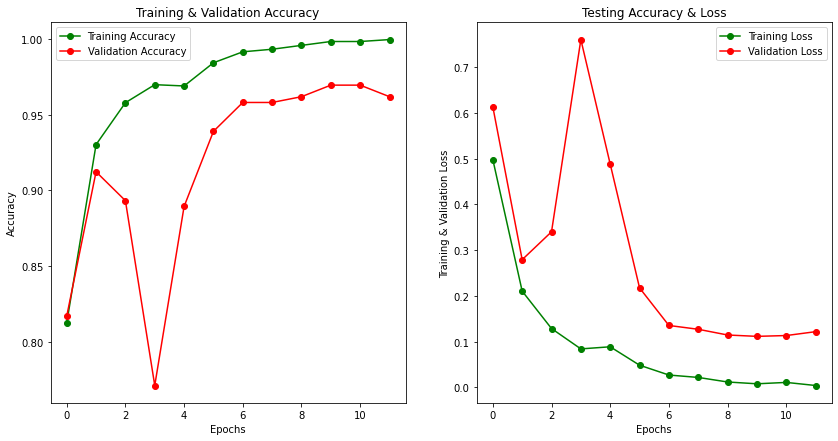

In [17]:
epochs = [i for i in range(12)]
fig, ax = plt.subplots(1,2)
train_acc = history1.history['accuracy']
train_loss = history1.history['loss']
val_acc = history1.history['val_accuracy']
val_loss = history1.history['val_loss']
fig.set_size_inches(14, 7)

ax[0].plot(epochs, train_acc, 'go-', label = 'Training Accuracy')
ax[0].plot(epochs, val_acc, 'ro-', label = 'Validation Accuracy')
ax[0].set_title('Training & Validation Accuracy')
ax[0].legend()
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')

ax[1].plot(epochs, train_loss, 'g-o', label ='Training Loss')
ax[1].plot(epochs, val_loss, 'r-o', label = 'Validation Loss')
ax[1].set_title('Testing Accuracy & Loss')
ax[1].legend()
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Training & Validation Loss')
plt.show()

1.4 Model Performance

In [18]:
# Evaluating Model.
result1=model1.evaluate(x_test, y_test)
print("Testing Loss :", result1[0])
print("Testing Accuracy :", result1[1]*100, "%")

21/21 [==============================] - 0s 22ms/step - loss: 0.0830 - accuracy: 0.9770
Testing Loss : 0.08298994600772858
Testing Accuracy : 97.70290851593018 %


In [19]:
predictions1 = model1.predict(x_test)
predictions1 = np.argmax(predictions1, axis = 1)
y_test_edit = np.argmax(y_test , axis = 1)

1.5 Classification Report.

In [20]:
# Classification report.
cf_report = sklearn.metrics.classification_report(y_test_edit, predictions1 )
print(cf_report)

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       104
           1       1.00      1.00      1.00       196
           2       0.95      0.98      0.97       184
           3       0.97      0.94      0.95       169

    accuracy                           0.98       653
   macro avg       0.98      0.98      0.98       653
weighted avg       0.98      0.98      0.98       653



1.6 Confusion Matrix

<AxesSubplot:>

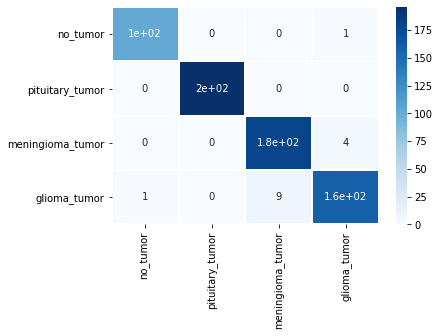

In [21]:
cf_matrix = sklearn.metrics.confusion_matrix(y_test_edit, predictions1)
sns.heatmap(cf_matrix, cmap = 'Blues', linewidth = 1, annot = True, xticklabels=labels, yticklabels=labels)

## 2. MODEL:Xception

In [22]:
# Importing the model and initializing.
from tensorflow.keras.applications import Xception
xception = Xception(weights = 'imagenet',include_top=False,input_shape=(IMAGE_SIZE,IMAGE_SIZE, 3))

83689472/83683744 [==============================] - 0s 0us/step


In [23]:
# Adding Top Layers.
model2 = xception.output
model2 = tf.keras.layers.GlobalAveragePooling2D()(model2)
model2 = tf.keras.layers.Dropout(0.5)(model2)
model2 = tf.keras.layers.Dense(4, activation = 'softmax')(model2)
model2 = tf.keras.models.Model(inputs = xception.input, outputs = model2)

2.1 Model Summary.

In [24]:
# Summary of the model.
model2.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 74, 74, 32)   864         input_2[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 74, 74, 32)   128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 74, 74, 32)   0           block1_conv1_bn[0][0]            
____________________________________________________________________________________________

In [25]:
# Compiling the model.
model2.compile(loss = 'categorical_crossentropy', optimizer ='Adam', metrics=['accuracy'])

In [26]:
# Callbacks.
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard
tensorboard = TensorBoard(log_dir = 'logs')
checkpoint = ModelCheckpoint("xception.h5",monitor="val_accuracy",save_best_only=True,mode="auto",verbose=1)
reduce_lr = ReduceLROnPlateau(monitor = 'val_accuracy', factor = 0.2, patience = 2, min_delta = 0.01,mode='auto',verbose=VERBOSE) ##Experiment 2 change factor, patience and min_delta

2.2 Training the model.

In [27]:
# Fitting the model
history2 = model2.fit(x_train, y_train, validation_split=0.1,epochs = 12,  verbose = VERBOSE, batch_size=BATCH_SIZE, callbacks=[tensorboard,checkpoint, reduce_lr])

Epoch 1/12
74/74 [==============================] - 21s 228ms/step - loss: 0.7256 - accuracy: 0.7085 - val_loss: 5.3164 - val_accuracy: 0.4542

Epoch 00001: val_accuracy improved from -inf to 0.45420, saving model to xception.h5
Epoch 2/12
74/74 [==============================] - 14s 192ms/step - loss: 0.2562 - accuracy: 0.9201 - val_loss: 1.5784 - val_accuracy: 0.7366

Epoch 00002: val_accuracy improved from 0.45420 to 0.73664, saving model to xception.h5
Epoch 3/12
74/74 [==============================] - 15s 200ms/step - loss: 0.1577 - accuracy: 0.9504 - val_loss: 1.2467 - val_accuracy: 0.7214

Epoch 00003: val_accuracy did not improve from 0.73664
Epoch 4/12
74/74 [==============================] - 14s 195ms/step - loss: 0.0865 - accuracy: 0.9743 - val_loss: 1.6451 - val_accuracy: 0.6679

Epoch 00004: val_accuracy did not improve from 0.73664

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
Epoch 5/12
74/74 [==============================] - 14s 190

2.3 Training, Loss vs epoch.

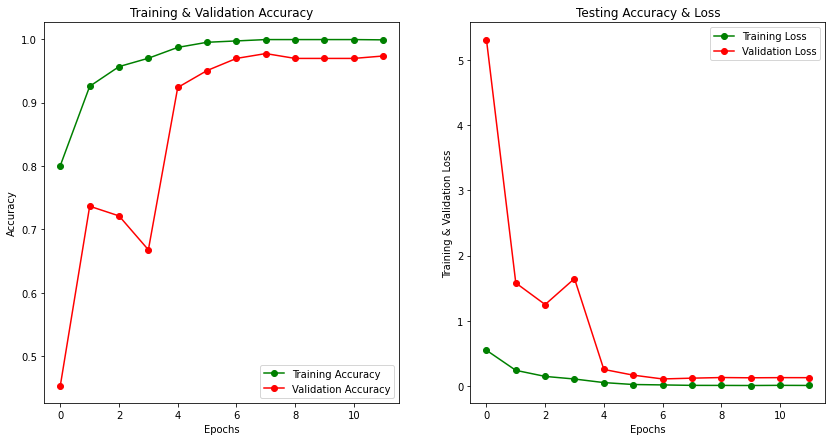

In [28]:
epochs = [i for i in range(12)]
fig, ax = plt.subplots(1,2)
train_acc = history2.history['accuracy']
train_loss = history2.history['loss']
val_acc = history2.history['val_accuracy']
val_loss = history2.history['val_loss']
fig.set_size_inches(14, 7)

ax[0].plot(epochs, train_acc, 'go-', label = 'Training Accuracy')
ax[0].plot(epochs, val_acc, 'ro-', label = 'Validation Accuracy')
ax[0].set_title('Training & Validation Accuracy')
ax[0].legend()
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')

ax[1].plot(epochs, train_loss, 'g-o', label ='Training Loss')
ax[1].plot(epochs, val_loss, 'r-o', label = 'Validation Loss')
ax[1].set_title('Testing Accuracy & Loss')
ax[1].legend()
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Training & Validation Loss')
plt.show()

2.4 Model Performance

In [29]:
# Evaluating Model.
result2=model2.evaluate(x_test, y_test)
print("Testing Loss :", result2[0])
print("Testing Accuracy :", result2[1]*100, "%")

21/21 [==============================] - 1s 37ms/step - loss: 0.1303 - accuracy: 0.9648
Testing Loss : 0.1302916407585144
Testing Accuracy : 96.4777946472168 %


In [30]:
predictions2 = model2.predict(x_test)
predictions2 = np.argmax(predictions2, axis = 1)
y_test_edit = np.argmax(y_test , axis = 1)

2.5 Classification Report.

In [31]:
# Classification report.
cf_report = sklearn.metrics.classification_report(y_test_edit, predictions2 )
print(cf_report)

              precision    recall  f1-score   support

           0       1.00      0.97      0.99       104
           1       0.98      0.99      0.99       196
           2       0.93      0.97      0.95       184
           3       0.96      0.92      0.94       169

    accuracy                           0.96       653
   macro avg       0.97      0.96      0.97       653
weighted avg       0.97      0.96      0.96       653



2.6 Confusion Matrix

<AxesSubplot:>

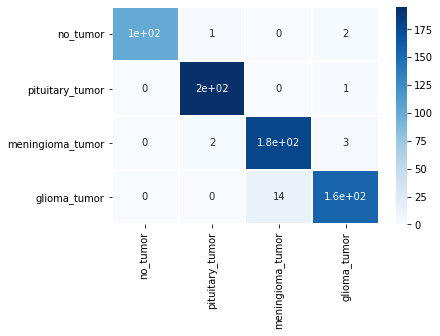

In [32]:
cf_matrix = sklearn.metrics.confusion_matrix(y_test_edit, predictions2)
sns.heatmap(cf_matrix, cmap = 'Blues', linewidth = 1, annot = True, xticklabels=labels, yticklabels=labels)

## 3. MODEL:MobileNet

In [33]:
# Importing the model and initializing.
from tensorflow.keras.applications.mobilenet import MobileNet
mblnt = MobileNet(weights = 'imagenet',include_top=False,input_shape=(IMAGE_SIZE,IMAGE_SIZE, 3))

17227776/17225924 [==============================] - 0s 0us/step


In [34]:
# Adding Top Layers.
model3 = mblnt.output
model3 = tf.keras.layers.GlobalAveragePooling2D()(model3)
model3 = tf.keras.layers.Dropout(0.5)(model3)
model3 = tf.keras.layers.Dense(4, activation = 'softmax')(model3)
model3 = tf.keras.models.Model(inputs = mblnt.input, outputs = model3)

3.1 Model Summary.

In [35]:
# Summary of the model.
model3.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
conv1 (Conv2D)               (None, 75, 75, 32)        864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 75, 75, 32)        128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 75, 75, 32)        0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 75, 75, 32)        288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 75, 75, 32)        128       
_________________________________________________________________
conv_dw_1_relu (ReLU)        (None, 75, 75, 32)        0   

In [36]:
# Compiling Model
model3.compile(loss = 'categorical_crossentropy', optimizer ='Adam', metrics=['accuracy'])

In [37]:
# Callbacks.
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard
tensorboard = TensorBoard(log_dir = 'logs')
checkpoint = ModelCheckpoint("mblnt.h5",monitor="val_accuracy",save_best_only=True,mode="auto",verbose=1)
reduce_lr = ReduceLROnPlateau(monitor = 'val_accuracy', factor = 0.2, patience = 10, min_delta = 0.0001,mode='auto',verbose=VERBOSE) ##Experiment 2 chnage  factor, patience and min_delta

3.2 Training the model.

In [38]:
# Fitting the model
history3 = model3.fit(x_train, y_train, validation_split=0.1, epochs = 12, verbose =VERBOSE, batch_size=BATCH_SIZE, callbacks=[tensorboard,checkpoint, reduce_lr])

Epoch 1/12
74/74 [==============================] - 9s 87ms/step - loss: 1.0716 - accuracy: 0.7007 - val_loss: 0.6551 - val_accuracy: 0.8435

Epoch 00001: val_accuracy improved from -inf to 0.84351, saving model to mblnt.h5
Epoch 2/12
74/74 [==============================] - 5s 69ms/step - loss: 0.3061 - accuracy: 0.9015 - val_loss: 0.6793 - val_accuracy: 0.8359

Epoch 00002: val_accuracy did not improve from 0.84351
Epoch 3/12
74/74 [==============================] - 5s 69ms/step - loss: 0.1733 - accuracy: 0.9432 - val_loss: 0.2761 - val_accuracy: 0.9313

Epoch 00003: val_accuracy improved from 0.84351 to 0.93130, saving model to mblnt.h5
Epoch 4/12
74/74 [==============================] - 5s 70ms/step - loss: 0.1658 - accuracy: 0.9444 - val_loss: 0.8443 - val_accuracy: 0.8206

Epoch 00004: val_accuracy did not improve from 0.93130
Epoch 5/12
74/74 [==============================] - 5s 70ms/step - loss: 0.1117 - accuracy: 0.9566 - val_loss: 0.1807 - val_accuracy: 0.9313

Epoch 00005: 

3.3 Training, Loss vs epoch.

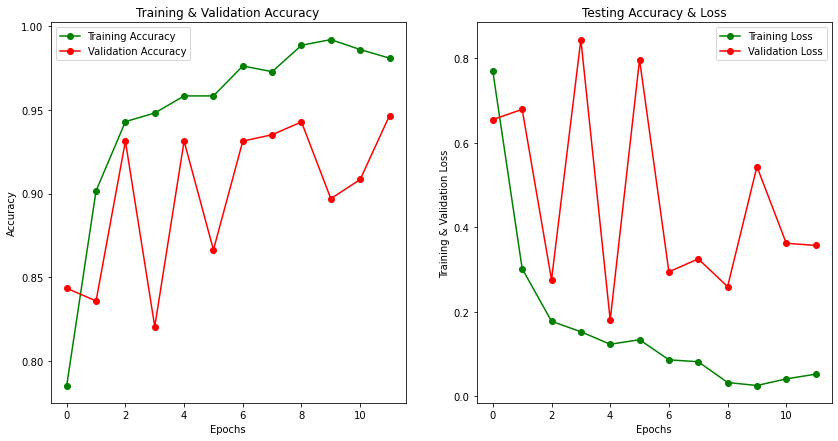

In [39]:
epochs = [i for i in range(12)]
fig, ax = plt.subplots(1,2)
train_acc = history3.history['accuracy']
train_loss = history3.history['loss']
val_acc = history3.history['val_accuracy']
val_loss = history3.history['val_loss']
fig.set_size_inches(14, 7)

ax[0].plot(epochs, train_acc, 'go-', label = 'Training Accuracy')
ax[0].plot(epochs, val_acc, 'ro-', label = 'Validation Accuracy')
ax[0].set_title('Training & Validation Accuracy')
ax[0].legend()
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')

ax[1].plot(epochs, train_loss, 'g-o', label ='Training Loss')
ax[1].plot(epochs, val_loss, 'r-o', label = 'Validation Loss')
ax[1].set_title('Testing Accuracy & Loss')
ax[1].legend()
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Training & Validation Loss')
plt.show()

3.4 Model Performance

In [40]:
# Evaluating Model.
result3=model3.evaluate(x_test, y_test)
print("Testing Loss :", result3[0])
print("Testing Accuracy :", result3[1]*100, "%")

21/21 [==============================] - 0s 11ms/step - loss: 0.2132 - accuracy: 0.9587
Testing Loss : 0.21324507892131805
Testing Accuracy : 95.86523771286011 %


In [41]:
predictions3 = model3.predict(x_test)
predictions3 = np.argmax(predictions3, axis = 1)
y_test_edit = np.argmax(y_test , axis = 1)

3.5 Classification Report.

In [42]:
# Classification report.
cf_report = sklearn.metrics.classification_report(y_test_edit, predictions3 )
print(cf_report)

              precision    recall  f1-score   support

           0       0.95      0.97      0.96       104
           1       0.99      0.97      0.98       196
           2       0.94      0.96      0.95       184
           3       0.95      0.93      0.94       169

    accuracy                           0.96       653
   macro avg       0.96      0.96      0.96       653
weighted avg       0.96      0.96      0.96       653



3.6 Confusion Matrix

<AxesSubplot:>

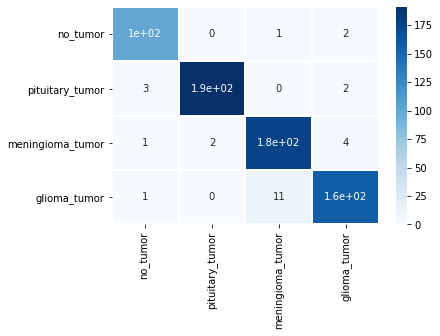

In [43]:
cf_matrix = sklearn.metrics.confusion_matrix(y_test_edit, predictions3)
sns.heatmap(cf_matrix, cmap = 'Blues', linewidth = 1, annot = True, xticklabels=labels, yticklabels=labels)

## 4. MODEL:ResNet50

In [44]:
# Importing the model and initializing.
from tensorflow.keras.applications.resnet import ResNet50
rsnet = ResNet50(weights = 'imagenet',include_top=False,input_shape=(IMAGE_SIZE,IMAGE_SIZE, 3))

94773248/94765736 [==============================] - 1s 0us/step


In [45]:
# Adding Top Layers.
model4 = rsnet.output
model4 = tf.keras.layers.GlobalAveragePooling2D()(model4)
model4 = tf.keras.layers.Dropout(0.5)(model4)
model4 = tf.keras.layers.Dense(4, activation = 'softmax')(model4)
model4 = tf.keras.models.Model(inputs = rsnet.input, outputs = model4)

4.1 Model Summary.

In [46]:
# Summary of the model.
model4.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 156, 156, 3)  0           input_4[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 75, 75, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 75, 75, 64)   256         conv1_conv[0][0]                 
____________________________________________________________________________________________

In [47]:
# Compiling Model
model4.compile(loss = 'categorical_crossentropy', optimizer ='Adam', metrics=['accuracy'])

In [48]:
# Callbacks.
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard
tensorboard = TensorBoard(log_dir = 'logfileres')
checkpoint = ModelCheckpoint("rsnet.h5",monitor="val_accuracy",save_best_only=True,mode="auto",verbose=1)
reduce_lr = ReduceLROnPlateau(monitor = 'val_accuracy', factor = 0.3, patience = 2, min_delta = 0.00001,mode='auto',verbose=VERBOSE) ##experiment 2 change factor, patience, min_delta

4.2 Training the model.

In [49]:
# Fitting the model
history4 = model4.fit(x_train, y_train,  validation_split=0.1,epochs = 15,  verbose =VERBOSE, batch_size=BATCH_SIZE, callbacks=[tensorboard,checkpoint, reduce_lr])

Epoch 1/15
74/74 [==============================] - 15s 132ms/step - loss: 1.1494 - accuracy: 0.6544 - val_loss: 27.4303 - val_accuracy: 0.1718

Epoch 00001: val_accuracy improved from -inf to 0.17176, saving model to rsnet.h5
Epoch 2/15
74/74 [==============================] - 7s 101ms/step - loss: 0.4213 - accuracy: 0.8525 - val_loss: 4.1554 - val_accuracy: 0.2557

Epoch 00002: val_accuracy improved from 0.17176 to 0.25573, saving model to rsnet.h5
Epoch 3/15
74/74 [==============================] - 7s 101ms/step - loss: 0.3289 - accuracy: 0.8956 - val_loss: 4.0025 - val_accuracy: 0.4656

Epoch 00003: val_accuracy improved from 0.25573 to 0.46565, saving model to rsnet.h5
Epoch 4/15
74/74 [==============================] - 7s 100ms/step - loss: 0.1800 - accuracy: 0.9453 - val_loss: 2.5724 - val_accuracy: 0.4122

Epoch 00004: val_accuracy did not improve from 0.46565
Epoch 5/15
74/74 [==============================] - 8s 101ms/step - loss: 0.1061 - accuracy: 0.9672 - val_loss: 0.4325 

4.3 Training, Loss vs epoch.

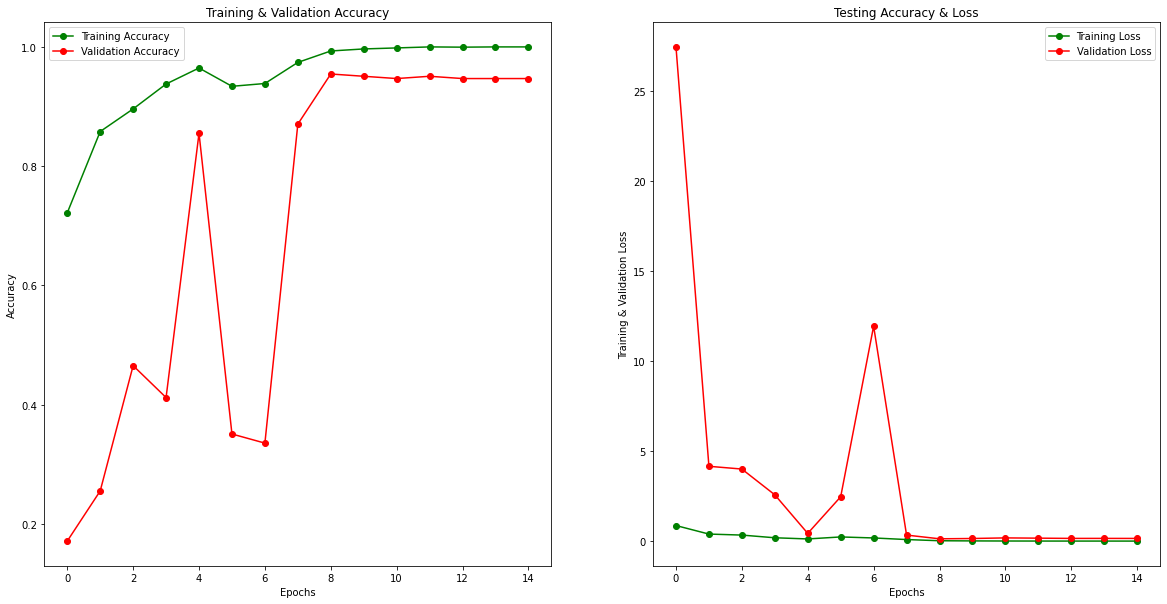

In [51]:
epochs = [i for i in range(15)]
fig, ax = plt.subplots(1,2)
train_acc = history4.history['accuracy']
train_loss = history4.history['loss']
val_acc = history4.history['val_accuracy']
val_loss = history4.history['val_loss']
fig.set_size_inches(20, 10)

ax[0].plot(epochs, train_acc, 'go-', label = 'Training Accuracy')
ax[0].plot(epochs, val_acc, 'ro-', label = 'Validation Accuracy')
ax[0].set_title('Training & Validation Accuracy')
ax[0].legend()
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')

ax[1].plot(epochs, train_loss, 'g-o', label ='Training Loss')
ax[1].plot(epochs, val_loss, 'r-o', label = 'Validation Loss')
ax[1].set_title('Testing Accuracy & Loss')
ax[1].legend()
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Training & Validation Loss')
plt.show()

4.4 Model Performance

In [52]:
# Evaluating Model.
result4=model4.evaluate(x_test, y_test)
print("Testing Loss :", result4[0])
print("Testing Accuracy :", result4[1]*100, "%")

21/21 [==============================] - 1s 31ms/step - loss: 0.1185 - accuracy: 0.9740
Testing Loss : 0.11853403598070145
Testing Accuracy : 97.39663004875183 %


In [53]:
predictions4 = model4.predict(x_test)
predictions4 = np.argmax(predictions4, axis = 1)
y_test_edit = np.argmax(y_test , axis = 1)

4.5 Classification Report.

In [54]:
# Classification report.
cf_report = sklearn.metrics.classification_report(y_test_edit, predictions4 )
print(cf_report)

              precision    recall  f1-score   support

           0       0.97      0.98      0.98       104
           1       0.99      0.99      0.99       196
           2       0.95      0.99      0.97       184
           3       0.98      0.93      0.95       169

    accuracy                           0.97       653
   macro avg       0.97      0.97      0.97       653
weighted avg       0.97      0.97      0.97       653



4.6 Confusion Matrix

<AxesSubplot:>

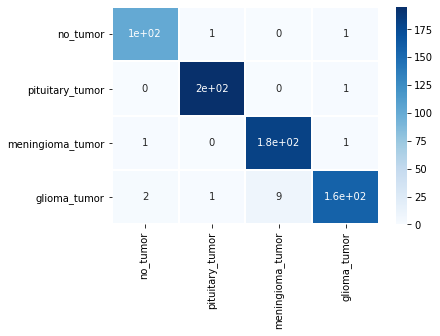

In [55]:
cf_matrix = sklearn.metrics.confusion_matrix(y_test_edit, predictions4)
sns.heatmap(cf_matrix, cmap = 'Blues', linewidth = 1, annot = True, xticklabels=labels, yticklabels=labels)